<a href="https://colab.research.google.com/github/marreapato/Forecasting_Paper_XAI/blob/main/antehoc/AttentionWeightsTrying.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Concatenate,Bidirectional
import tensorflow as tf


# Download stock data using yfinance
symbol = "^BVSP"
data = yf.download(symbol, '2007-01-01', '2023-10-17')
df = pd.DataFrame(data['Close'])

# Normalize the data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Create sequences for training
sequence_length = 1
X, y = [], []
for i in range(len(df_scaled) - sequence_length):
    X.append(df_scaled[i:i+sequence_length])
    y.append(df_scaled[i+sequence_length])

X, y = np.array(X), np.array(y)

# Time-based train-test split
split_percentage = 0.8
split_index = int(split_percentage * len(df_scaled))

X_train, X_test, y_train, y_test = X[:split_index], X[split_index:], y[:split_index], y[split_index:]


tf.random.set_seed(42)
# Build the model with attention mechanism
input_layer = Input(shape=(sequence_length, 1))
lstm_layer = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
attention = Attention()([lstm_layer, lstm_layer])
context = attention * lstm_layer
output_layer = Dense(1)(context)

# Concatenate the output and attention weights
model = Model(inputs=input_layer, outputs=[output_layer, attention])
model.compile(optimizer='adam', loss=['mean_squared_error', None])

# Train the model
model.fit(X_train, [y_train, np.zeros_like(y_train)], epochs=50, batch_size=32, validation_data=(X_test, [y_test, np.zeros_like(y_test)]))


[*********************100%%**********************]  1 of 1 completed


Epoch 1/50
104/104 [==============================] - 6s 18ms/step - loss: 0.0918 - dense_2_loss: 0.0918 - val_loss: 0.2062 - val_dense_2_loss: 0.2062
Epoch 2/50
104/104 [==============================] - 1s 7ms/step - loss: 0.0077 - dense_2_loss: 0.0077 - val_loss: 0.0110 - val_dense_2_loss: 0.0110
Epoch 3/50
104/104 [==============================] - 1s 7ms/step - loss: 0.0024 - dense_2_loss: 0.0024 - val_loss: 0.0014 - val_dense_2_loss: 0.0014
Epoch 4/50
104/104 [==============================] - 1s 7ms/step - loss: 5.1537e-04 - dense_2_loss: 5.1537e-04 - val_loss: 0.0037 - val_dense_2_loss: 0.0037
Epoch 5/50
104/104 [==============================] - 1s 7ms/step - loss: 3.2767e-04 - dense_2_loss: 3.2767e-04 - val_loss: 0.0015 - val_dense_2_loss: 0.0015
Epoch 6/50
104/104 [==============================] - 1s 8ms/step - loss: 1.8087e-04 - dense_2_loss: 1.8087e-04 - val_loss: 3.3715e-04 - val_dense_2_loss: 3.3715e-04
Epoch 7/50
104/104 [==============================] - 1s 12ms/step 

In [22]:
# Predict on the test set
predictions, attention_weights = model.predict(X_test)


26/26 [==============================] - 1s 3ms/step


In [23]:
train_predictions, train_attention_weights = model.predict(X_train)


104/104 [==============================] - 0s 4ms/step


In [24]:
train_attention_weights[:,:,0].shape

(3323, 1)

In [25]:
y_train.shape

(3323, 1)

In [26]:
attention_weights.shape

(830, 1, 256)

In [27]:
predictions.reshape(-1,1).shape

(830, 1)

In [28]:
y_test.shape

(830, 1)

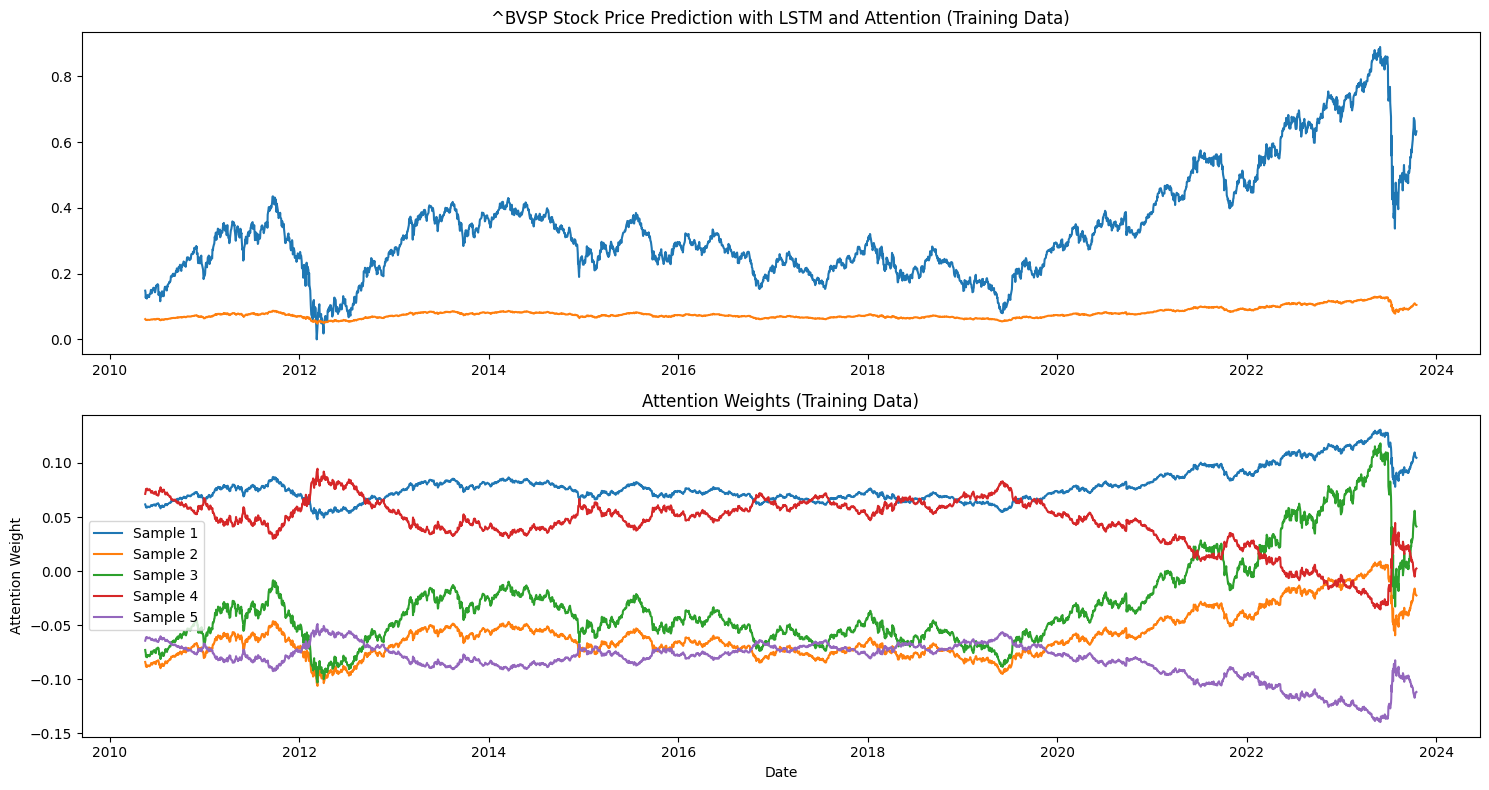

In [41]:
# Plot the attention weights for the training data
plt.figure(figsize=(15, 8))

# Plotting actual vs predicted stock prices
plt.subplot(2, 1, 1)
plt.plot(df.index[-len(y_train):], y_train, label='Actual')
#plt.plot(df.index[-len(train_predictions):], train_predictions.reshape(-1,1), label='Predicted')
plt.plot( df.index[-len(train_attention_weights):], train_attention_weights[:,:,0], label='Sample')
plt.title(f'{symbol} Stock Price Prediction with LSTM and Attention (Training Data)')
# Plotting attention weights for the training data
plt.subplot(2, 1, 2)
for i in range(5):  # Plot attention weights for the first 5 samples in the training set
    plt.plot(df.index[-len(train_attention_weights):], train_attention_weights[:, :, i], label=f'Sample {i + 1}')

plt.title('Attention Weights (Training Data)')
plt.xlabel('Date')
plt.ylabel('Attention Weight')
plt.legend()


plt.tight_layout()
plt.show()

In [36]:
train_attention_weights.reshape(3323, 256).mean(axis=1)

array([0.00435031, 0.00432446, 0.00431279, ..., 0.00589576, 0.00583052,
       0.00581612], dtype=float32)